In [137]:
import numpy as np
import matplotlib.pyplot as plt
import function as func
import os
import sys

outdir = './plot/result_figure/yfactor/'
if not os.path.isdir(outdir):
    os.makedirs(outdir)
    pass

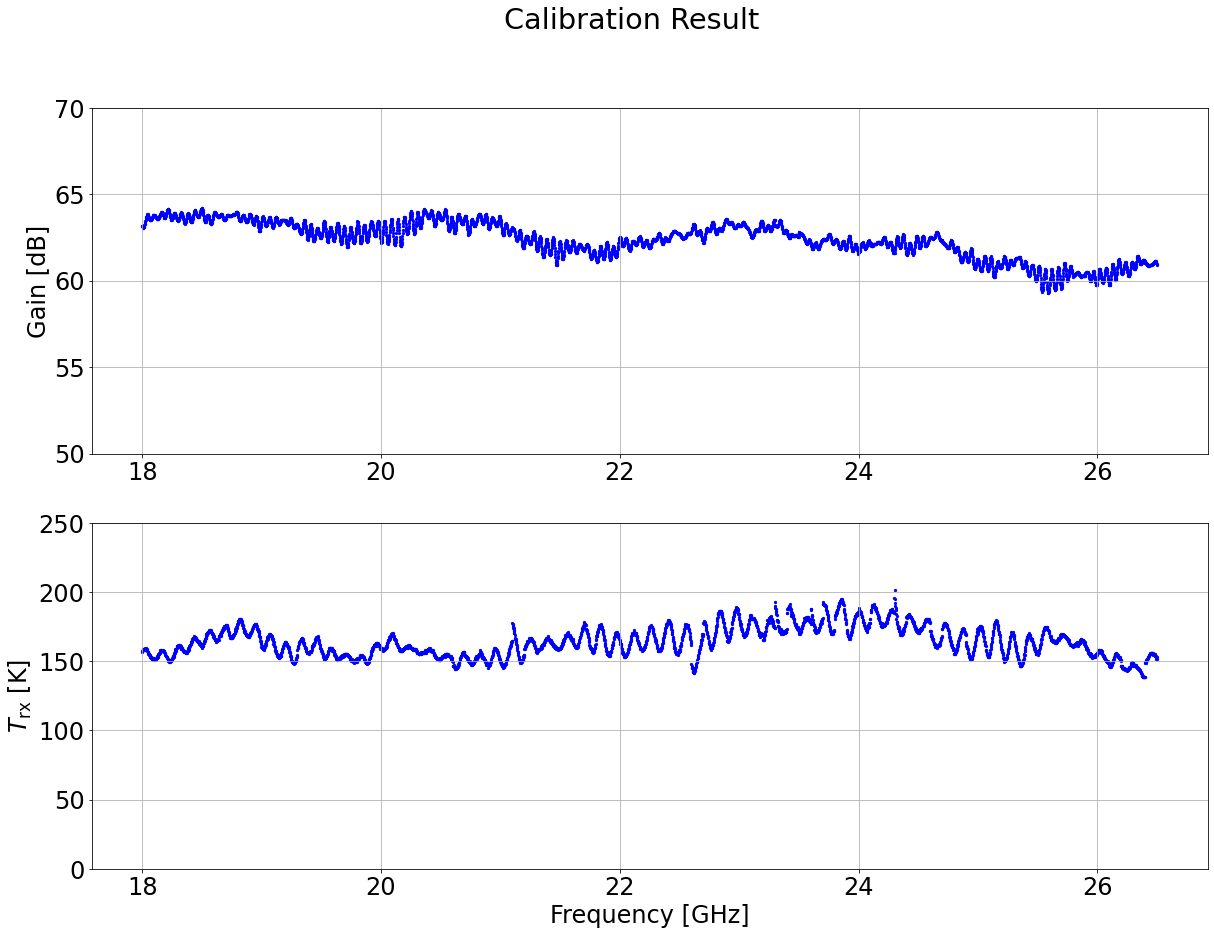

In [138]:
plt.rcParams["font.size"] = 24
fig, axes = plt.subplots(2,1,figsize=(20,14), squeeze=False, sharex=False)
plt.suptitle("Calibration Result")


y = func.csv_to_array("/data/ms2840a/result_data/yfactor_result_rebin2MHz.csv")

ax = axes[0][0]
ax.scatter(y["freq"], 10*np.log10(y["Gain"]), s=5, color="blue", label="null sample")
ax.set_ylabel("Gain [dB]")
ax.grid()
ax.set_ylim([50,70])
ax.set_yticks([50, 55, 60, 65, 70])

ax = axes[1][0]
ax.scatter(y["freq"], y["Trx"], s=5, color="blue", label="null sample")
ax.set_xlabel("Frequency [GHz]")
ax.set_ylabel(r"$T_{\rm rx}$ [K]")
ax.set_ylim([0,250])
ax.grid()

plt.savefig(f"{outdir}/gain_Trx.pdf")

0.06835459615129354
931.04861633488
42253.57860391085


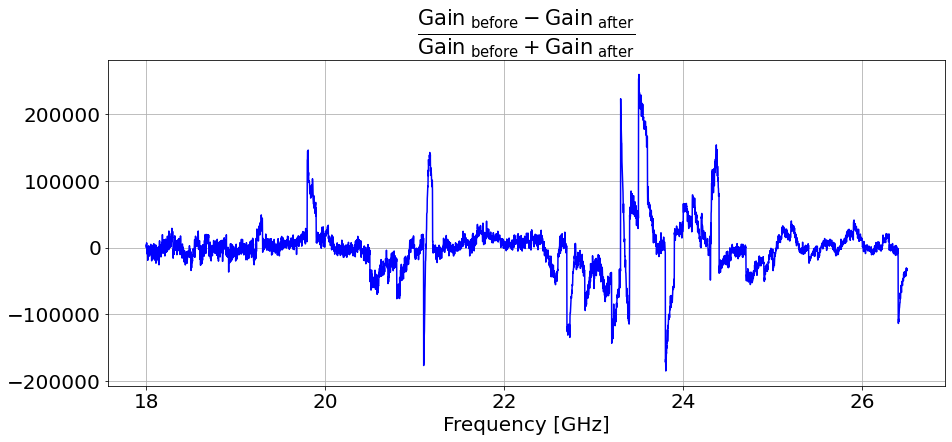

In [33]:
plt.rcParams["font.size"] = 20
plt.figure(figsize=(15,6))
ratio = (y["Gain_ini"]-y["Gain_fin"])/(y["Gain_ini"]+y["Gain_fin"])
plt.plot(y["freq"], y["Gain_ini"]-y["Gain_fin"], color="blue")
plt.title(r"$\rm \frac{Gain_{~before}-Gain_{~after}}{Gain_{~before}+Gain_{~after}}$", fontsize=30)
plt.ylabel("")
plt.xlabel("Frequency [GHz]")
#plt.yscale("log")
plt.grid()
print(np.max(ratio))
#plt.ylim([-0.15, 0.15])
print(np.mean(y["Gain_ini"]-y["Gain_fin"]))
print(np.std(y["Gain_ini"]-y["Gain_fin"]))

plt.savefig(f"{outdir}/gain_diffratio_before_after.pdf")

# Calculate NET

上で計算される $T_{\mathrm{rx}}$ は $\eta_{\mathrm{win}}$ (黒体=窓を見込む beam の割合) で大きく評価されている

今回のクライオスタット込みで Y-factor 測定した場合は
$$
\begin{align}
    G & \equiv \frac{ G^\mathrm{real} \eta_\mathrm{win} }{2}  &[\mbox{小高修論 (5.5)}] \\
    P_\mathrm{out} &= G k_\mathrm{B} ( T_\mathrm{BB} + T_\mathrm{rx} )\Delta \nu  &[\mbox{小高修論 (5.10)}] \\
    P_{\mathrm{out}} &= \frac{ G^\mathrm{real}\eta_\mathrm{win} }{2} k_\mathrm{B} (T_\mathrm{BB} + T_\mathrm{rx} )\Delta \nu &(1)\\
\end{align}
$$
という式に従って $T_\mathrm{rx}$ を求めているが、

実際の $T^\mathrm{real}_\mathrm{rx}$ は受信機の内部雑音であり、$\eta_\mathrm{win}$ がかからないはずなので,
$$
    P_{\mathrm{out}} = \frac{ G^\mathrm{real} }{2} k_\mathrm{B} (\eta_\mathrm{win}T_\mathrm{BB} + T_\mathrm{rx}^\mathrm{real} )\Delta \nu  \qquad (2)
$$
とかけるべきである。
(入射する黒体輻射には $\eta_\mathrm{win}$ がかかる。)

式(1), (2)を比較すると
$$
    T_\mathrm{rx}^\mathrm{real} = \eta_\mathrm{win}T_\mathrm{rx}
$$


また、$T_\mathrm{load}$ (入射熱放射) については、
$$
\begin{align}
    P_{\mathrm{out, search}} &= \frac{ G^\mathrm{real} }{2} k_\mathrm{B} (\eta_\mathrm{win}T_\mathrm{load} + T_\mathrm{rx}^\mathrm{real} )\Delta \nu  \qquad \\
                     &= G k_\mathrm{B} (T_\mathrm{load} + T_\mathrm{rx} )\Delta \nu \qquad (\mbox{式(5.5) より})\\
    T_{\mathrm{load}} &= \frac{ P_{\mathrm{out, search}} }{G k_\mathrm{B}\Delta\nu} - T_\mathrm{rx}
\end{align}
$$
となり、$P_\mathrm{out, search}$ (探索するセットアップでの出力) から上で求めた $G, T_\mathrm{rx}$ (real の方ではない) を用いて計算できる

$T_\mathrm{sys}$ は
$$
    T_\mathrm{sys} = T_\mathrm{load} + T_\mathrm{rx}^\mathrm{rx} = T_\mathrm{load} + \eta_\mathrm{win} T_\mathrm{rm}
$$

$\mathrm{NEP}$ は, $P_{noise} = k_B T_{sys} \Delta \nu$ と雑音パワーを書けるので
$$
\begin{align}
 \mathrm{NEP} &= \sqrt{2 P_{noise} k_B T_{sys}} \\
     &= \sqrt{2\Delta\nu} k_B T_{sys} \\
     &= \sqrt{2\Delta\nu} k_B (T_{load} + \eta_\mathrm{win} T_{rx})
\end{align}
$$
注) $\sqrt{2}$ は $\mathrm{NEP}$ が 0.5 sec の時間積分でのノイズを表しているため。

In [139]:
## eta_win 
# Function of eta_window
# Obtained from Aeff_analysis.ipynb
# function(nu) = a(nu[GHz]-22 GHz) + b
# a = 0.017279 +/- 0.00018
# b = 0.238357 +/- 0.000465
def eta_win(freq, a=0.017279, b=0.238357):
    return a * (freq - 22.) + b

In [140]:
# Parameters
rbw = 300. # frequencyc Resolution Band Width (RBW) [Hz]
from scipy import constants
k_B, _unit_k_B, _uncertainty = constants.physical_constants['Boltzmann constant']
print(f'{k_B} [{_unit_k_B}]')

1.380649e-23 [J K^-1]


In [141]:
## Get P_out
data = func.csv_to_array("/data/ms2840a/result_data/signal_raw_data.csv")

print(data.keys())

freqs_Pout = data['freq'] # GHz
Pout = data['W']
print(f'freqs (size:{len(freqs_Pout)}) = {freqs_Pout}')
print(f'Pout (size:{len(Pout)}) = {Pout}')

dict_keys(['freq', 'W'])
freqs (size:111413750) = [18.00000002 18.00000009 18.00000017 ... 26.49999983 26.49999991
 26.49999998]
Pout (size:111413750) = [1.85033549e-12 1.86950361e-12 1.88626766e-12 ... 1.30718744e-12
 1.31516017e-12 1.31641159e-12]


In [142]:
n_mean = 250
# Mean in each n_mean length
_freqs_Pout = freqs_Pout.reshape((int)(len(freqs_Pout)/n_mean), n_mean)
print(f'_freqs_Pout ({_freqs_Pout.shape}) = {_freqs_Pout}')
freqs_Pout_mean = np.average(_freqs_Pout, axis=1)
print(f'freqs_Pout_mean (size:{len(freqs_Pout_mean)}) = {freqs_Pout_mean}')
_Pout = Pout.reshape((int)(len(Pout)/n_mean), n_mean)
print(f'_Pout ({_Pout.shape}) = {_Pout}')
Pout_mean = np.average(_Pout, axis=1)
print(f'Pout_mean (size:{len(Pout_mean)}) = {Pout_mean}')

_freqs_Pout ((445655, 250)) = [[18.00000002 18.00000009 18.00000017 ... 18.00001886 18.00001894
  18.00001901]
 [18.00001909 18.00001917 18.00001924 ... 18.00003793 18.00003801
  18.00003809]
 [18.00003816 18.00003824 18.00003831 ... 18.00005701 18.00005708
  18.00005716]
 ...
 [26.49994284 26.49994292 26.49994299 ... 26.49996169 26.49996176
  26.49996184]
 [26.49996191 26.49996199 26.49996207 ... 26.49998076 26.49998083
  26.49998091]
 [26.49998099 26.49998106 26.49998114 ... 26.49999983 26.49999991
  26.49999998]]
freqs_Pout_mean (size:445655) = [18.00000951 18.00002859 18.00004766 ... 26.49995234 26.49997141
 26.49999049]
_Pout ((445655, 250)) = [[1.85033549e-12 1.86950361e-12 1.88626766e-12 ... 1.86905869e-12
  1.87836224e-12 1.89404326e-12]
 [1.90930480e-12 1.91679680e-12 1.91531927e-12 ... 1.89028163e-12
  1.89426969e-12 1.89948280e-12]
 [1.89985773e-12 1.89352523e-12 1.88697316e-12 ... 1.87844647e-12
  1.87588497e-12 1.87648397e-12]
 ...
 [1.30846255e-12 1.31024361e-12 1.3080951

In [143]:
# Get y value at x from y_array with different x_array
def get_betweenY(x, x_array, y_array):
    x_diff = x_array - x
    #x_diff_min = np.min(np.abs(x_diff))
    #min_index = np.where(abs(x_diff) == x_diff_min)[0]
    min_index = np.abs(x_diff).argmin()
    x_min = x_array[min_index]
    y_min = y_array[min_index]
    min2_index = min_index + 1 if x - x_min > 0. else min_index - 1 # Get next index
    x_min2 = x_array[min2_index]
    y_min2 = y_array[min2_index]
    return ( y_min*(x - x_min2) + y_min2*(x_min - x) ) / (x_min - x_min2)

In [144]:
# Get gain, Trx
freqs = y['freq'] # GHz
print(f'freqs (size:{len(freqs)}) = {freqs}')
gains = y["Gain"]
Trx = y['Trx']
Trx_real = Trx * eta_win(freqs)

freqs (size:4250) = [17.99975 18.00175 18.00375 ... 26.49375 26.49575 26.49775]


In [145]:
# Get Pout at freqs (Takes a time)
Pout2 = []
for i, _freq in enumerate(freqs):
    if i%100 == 0: print(f'i = {i}/{len(freqs)}')
    _Pout = get_betweenY(_freq, freqs_Pout_mean, Pout_mean)
    Pout2.append(_Pout)
    pass
Pout2 = np.array(Pout2)

i = 0/4250
i = 100/4250
i = 200/4250
i = 300/4250
i = 400/4250
i = 500/4250
i = 600/4250
i = 700/4250
i = 800/4250
i = 900/4250
i = 1000/4250
i = 1100/4250
i = 1200/4250
i = 1300/4250
i = 1400/4250
i = 1500/4250
i = 1600/4250
i = 1700/4250
i = 1800/4250
i = 1900/4250
i = 2000/4250
i = 2100/4250
i = 2200/4250
i = 2300/4250
i = 2400/4250
i = 2500/4250
i = 2600/4250
i = 2700/4250
i = 2800/4250
i = 2900/4250
i = 3000/4250
i = 3100/4250
i = 3200/4250
i = 3300/4250
i = 3400/4250
i = 3500/4250
i = 3600/4250
i = 3700/4250
i = 3800/4250
i = 3900/4250
i = 4000/4250
i = 4100/4250
i = 4200/4250


In [146]:
Tload = Pout2/(gains*k_B*rbw) - Trx
Tsys = Tload + Trx_real
NEP = np.sqrt(2.*rbw)*k_B*Tsys

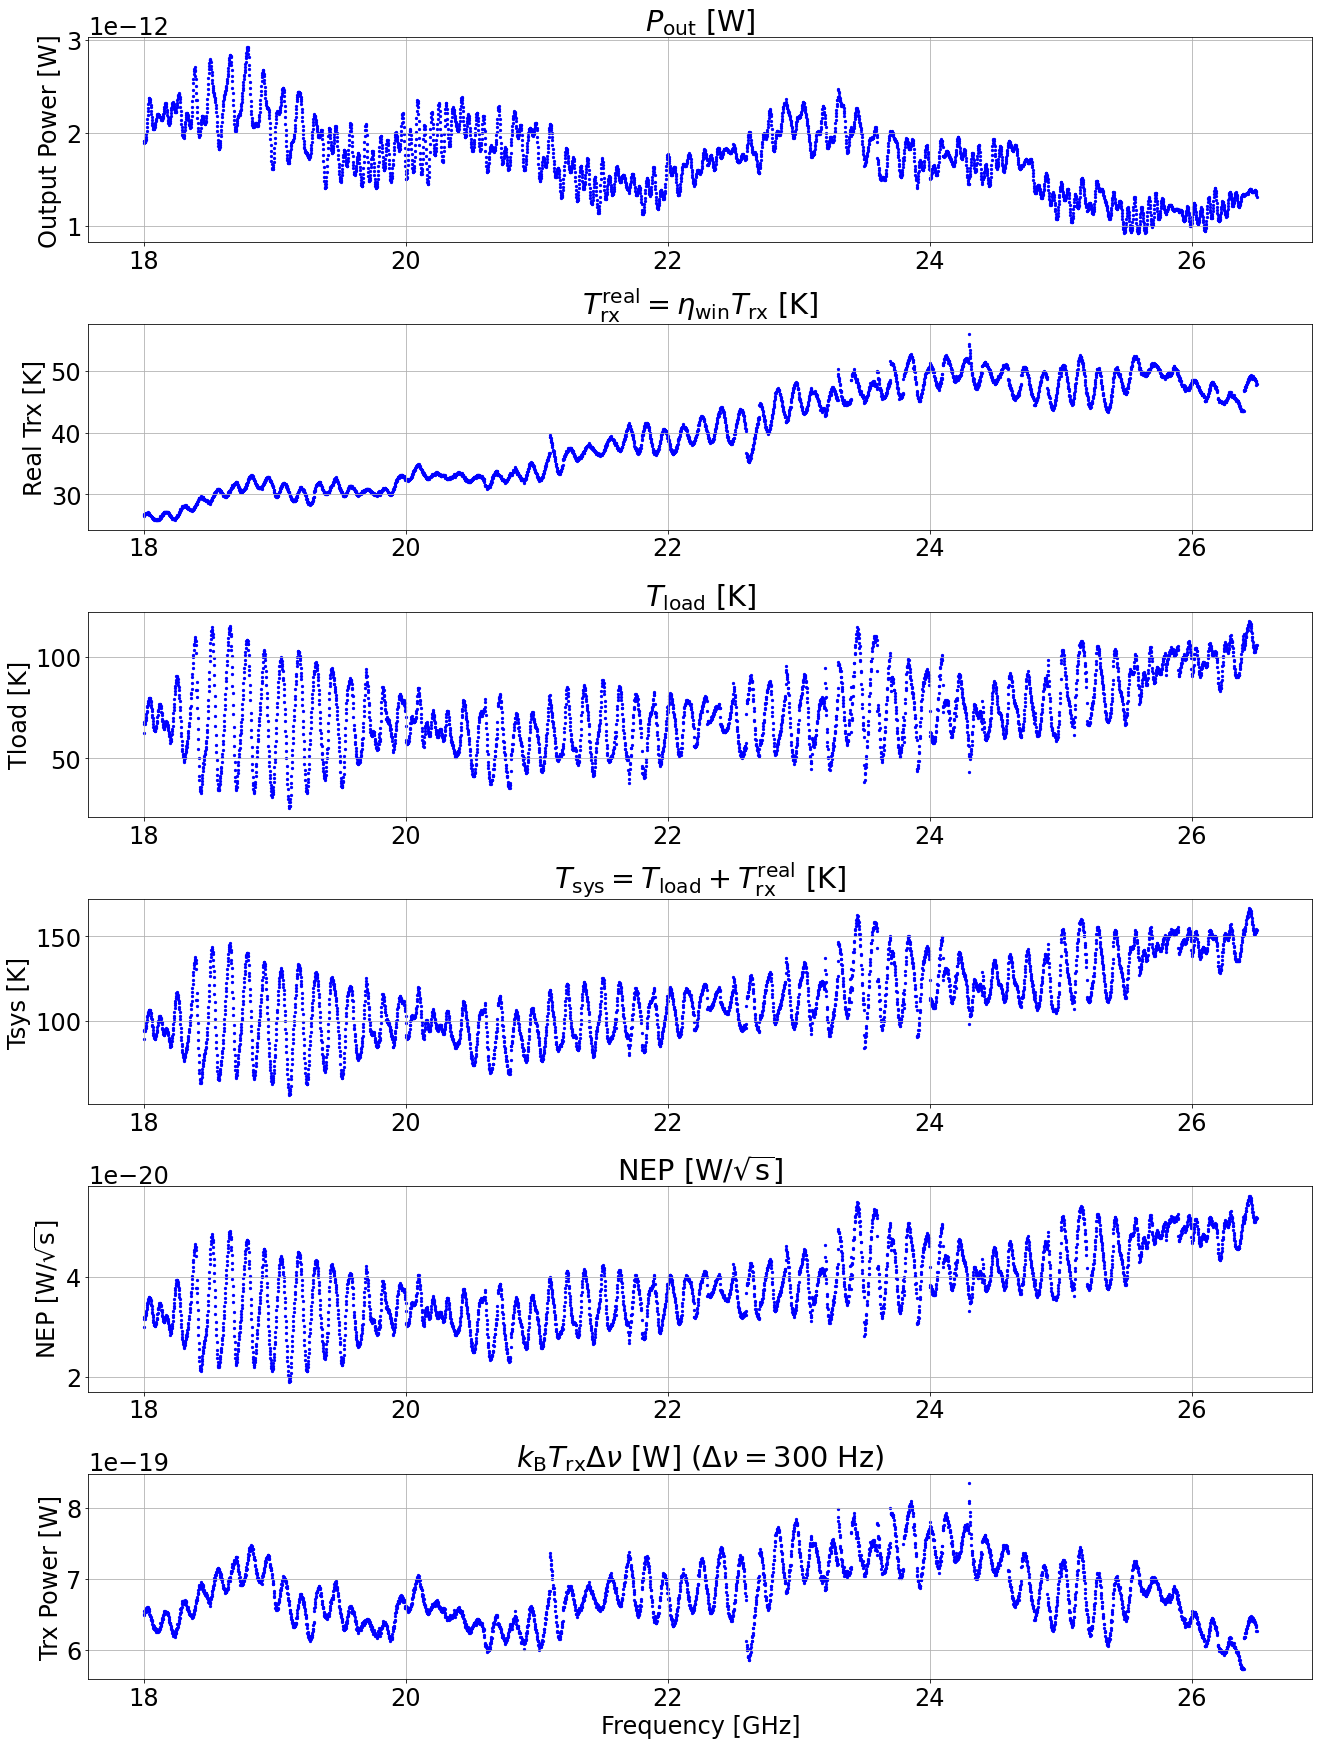

In [153]:
# Plot
plt.rcParams["font.size"] = 24
fig, axes = plt.subplots(6,1,figsize=(20,24), squeeze=False, sharex=False)
fig.tight_layout()

ax = axes[0][0]
ax.scatter(freqs, Pout2, s=5, color="blue", label="$P_{\mathrm{out}}$")
ax.set_ylabel("Output Power [W]")
ax.set_title(r"$P_{\rm{out}}$ [W]")
ax.grid()

ax = axes[1][0]
ax.scatter(freqs, Trx_real, s=5, color="blue", label="$T_{\mathrm{rx}}^{\mathrm{real}$")
ax.set_ylabel("Real Trx [K]")
ax.set_title(r"$T_{\rm{rx}}^{\rm{real}} = \eta_{\rm{win}} T_{\rm{rx}}$ [K]")
ax.grid()

ax = axes[2][0]
ax.scatter(freqs, Tload, s=5, color="blue", label="$T_{\mathrm{load}}$")
ax.set_ylabel("Tload [K]")
ax.set_title(r"$T_{\mathrm{load}}$ [K]")
ax.grid()

ax = axes[3][0]
ax.scatter(freqs, Tsys, s=5, color="blue", label="$T_{\mathrm{sys}}$")
ax.set_ylabel("Tsys [K]")
ax.set_title(r"$T_{\mathrm{sys}} = T_{\mathrm{load}} + T_\mathrm{rx}^{\mathrm{real}}$ [K]")
ax.grid()

ax = axes[4][0]
ax.scatter(freqs, NEP, s=5, color="blue", label="NEP")
ax.set_ylabel(r"NEP [W/$\sqrt{\mathrm{s}}$]")
ax.set_title(r"NEP [W/$\sqrt{\mathrm{s}}$]")
ax.grid()

ax = axes[5][0]
ax.scatter(freqs, k_B*Trx*300, s=5, color="blue", label=r"$k_{\mathrm{B}} T_{\mathrm{rx}} \Delta \nu$")
ax.set_ylabel("Trx Power [W]")
ax.set_title(r"$k_{\mathrm{B}} T_{\mathrm{rx}} \Delta \nu$ [W] ($\Delta \nu= 300$ Hz)")
ax.grid()


ax.set_xlabel(r"Frequency [GHz]")

fig.subplots_adjust(hspace=0.4, left=0.10, right=0.95, bottom=0.0, top=0.95)

fig.savefig(f"{outdir}/RealTrx_Tsys_NEP.pdf")